# Quantum Approximate Optimization Algorithm

In this jupyter notebook we implement in Qiskit the QAOA algorithm for the Max Cut problem. 

In [16]:
import networkx as nx

import matplotlib.pyplot as plt
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA
from qiskit import *

### 0. Draw the graph

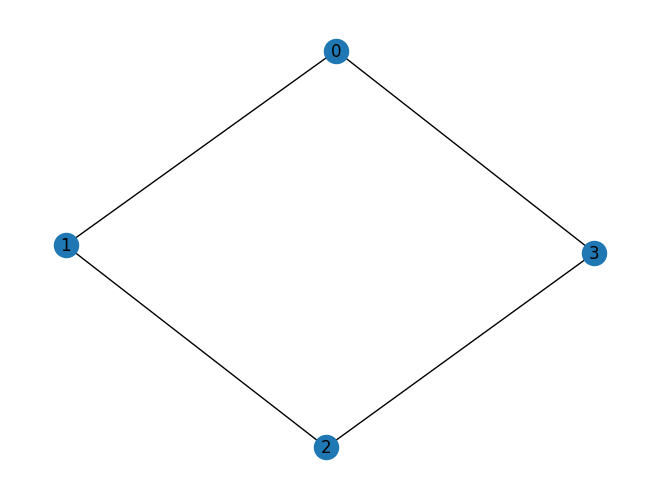

In [3]:
graph = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 0)])

nx.draw(graph, with_labels=True)

### 1. Draw the circuit

In [14]:
def create_circuit(params):
    """
    Create the quantum circuit for the MaxCut problem
    """
    
    # get n. of qubits and layers
    n_q = max(max(graph.edges())) + 1 # find the highest integer
    n_l = int(len(params)/2)
    
    # params
    params_rx = [params[2*i] for i in range(n_l)]
    params_rz = [params[2*i + 1] for i in range(n_l)]

    # define circuit
    circ = QuantumCircuit(n_q, n_q)

    # first layer of H gates 
    circ.h(range(n_q))
    
    # for every layer
    for l in range(n_l):
        
        # layer of cnots and Rz
        for edge in graph.edges():
            i = edge[0]
            j = edge[1]
            
            circ.cx(i, j)
            circ.rz(params_rz[l], j)
            circ.cx(i, j)
        
        # layer of rotations Rx
        for w in range(n_q):
            circ.rx(params_rx[l], w)
                
        # barrier
        circ.barrier(range(n_q))
        
    # add the measurements
    circ.measure(range(n_q), range(n_q))
        
    return circ

In [5]:
# draw the circuit [[gammas], [betas]]
initial_params = np.zeros(2)

qc = create_circuit(initial_params)
qc.draw()

[0.0]


┌───┐                                               ┌───────┐         »
q_0: ┤ H ├──■─────────────■────■──────────────────────■──┤ RX(0) ├─────────»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │                      │  └───────┘┌───────┐»
q_1: ┤ H ├┤ X ├┤ RZ(0) ├┤ X ├──┼──────■───────────────┼──────■────┤ RX(0) ├»
     ├───┤└───┘└───────┘└───┘  │    ┌─┴─┐  ┌───────┐  │    ┌─┴─┐  └───────┘»
q_2: ┤ H ├─────────────────────┼────┤ X ├──┤ RZ(0) ├──┼────┤ X ├──────■────»
     ├───┤                   ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐  └───┘    ┌─┴─┐  »
q_3: ┤ H ├───────────────────┤ X ├┤ RZ(0) ├─────────┤ X ├───────────┤ X ├──»
     └───┘                   └───┘└───────┘         └───┘           └───┘  »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                             ░ ┌─┐         
«q_0: ────────────────────────░─┤M├─────────
«                             ░ └╥┘┌─┐      
«q_1: ────────────────────────░──╫─┤M├──────
«                   ┌───────┐ ░  ║ └╥┘┌─┐   
«q_2: ───────────■──┤ RX(0) ├─░──╫──╫─┤M├───
«     ┌───────┐┌─┴─┐├───────┤ ░  ║  ║ └╥┘┌─┐
«q_3: ┤ RZ(0) ├┤ X ├┤ RX(0) ├─░──╫──╫──╫─┤M├
«     └───────┘└───┘└───────┘ ░  ║  ║  ║ └╥┘
«c: 4/═══════════════════════════╩══╩══╩══╩═
«                                0  1  2  3

### 2. Define the objective function

In [6]:
def maxcut_obj(bits):
    """
    QUBO function of the Max Cut problem
    """

    obj = 0
    for i, j in graph.edges():
        x_i = int(bits[i])
        x_j = int(bits[j])
        
        obj -= x_i + x_j - 2 * x_i * x_j
        
    return obj


def compute_average_obj(counts):
    """
    Compute the average value from the counts
    """

    obj = 0
    n_shots = 0
    
    for bits, counts in counts.items():
        
        obj += maxcut_obj(bits) * counts
        
        n_shots += counts

    return obj/n_shots


def run_circuit(theta):
    """
    Final objective function to minimize
    """

    backend = Aer.get_backend('qasm_simulator')

    qc = create_circuit(theta)
    
    counts = backend.run(qc).result().get_counts()
    
    avg_obj = compute_average_obj(counts)

    return avg_obj

### 3.0 Visualise the results

/Users/alessandro/.pyenv/versions/3.9.10/lib/python3.9/site-packages/qiskit/visualization/counts_visualization.py:181: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/alessandro/.pyenv/versions/3.9.10/lib/python3.9/site-packages/qiskit/visualization/counts_visualization.py:181: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/alessandro/.pyenv/versions/3.9.10/lib/python3.9/site-packages/qiskit/visualization/counts_visualization.py:181: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/Users/alessandro/.pyenv/versions/3.9.10/lib/python3.9/site-packages/qiskit/visualization/counts_visualization.py:181: MatplotlibDeprecationWarning:

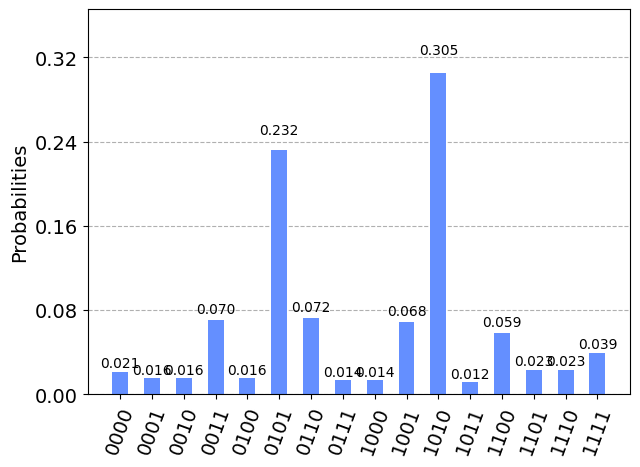

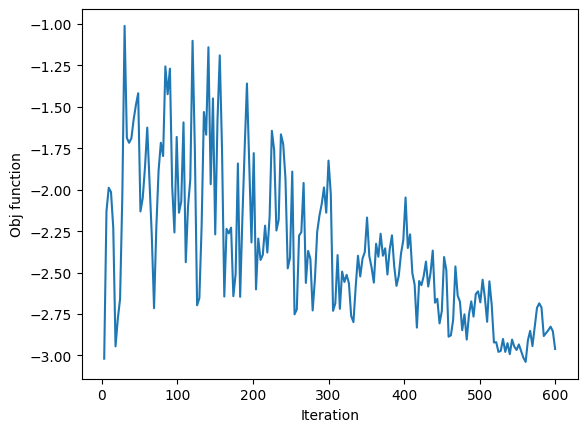

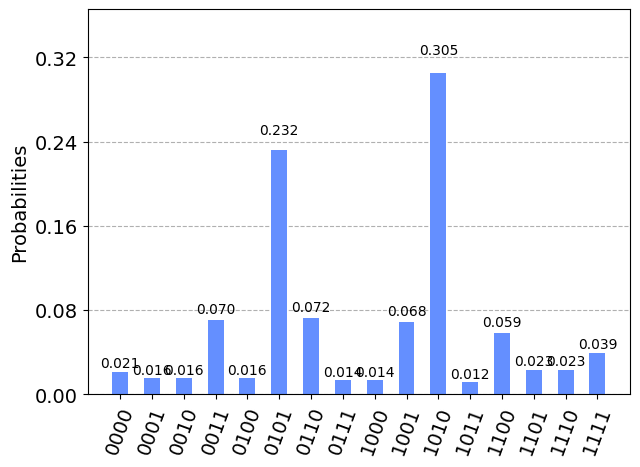

In [19]:
# n layers & intial parameters
n_layers = 1
initial_params = np.zeros(2*n_layers)

# save values for plotting
xs = []
obj_values = []
def callback(a, b, c, d, e):
    xs.append(a)
    obj_values.append(c)
    
# run the optimizew
opt = SPSA(maxiter=200, callback=callback)
res = opt.optimize(2, run_circuit, initial_point = initial_params)

# plot the objective function
plt.plot(xs, obj_values)
plt.xlabel("Iteration")
plt.ylabel("Obj function")

# run the circuit with the optimal weights
backend = Aer.get_backend('qasm_simulator')
qc_res = create_circuit(res[0])
counts = backend.run(qc_res, shots=512).result().get_counts()
plot_histogram(counts)